In [21]:
import pathlib

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.ndimage import gaussian_filter

from scipy.interpolate import interp1d
import gala.coordinates as gc
from pyia import GaiaData

In [40]:
gaia = at.Table.read('../data/gd1-dr3-polygon.fits')
ps1 = at.Table.read('../data/PS1-DR2_GD1-DR3_xm.fits')
joined = at.join(gaia, ps1, keys='source_id')
joined = at.unique(joined, keys='source_id')

In [41]:
g = GaiaData(joined)

In [48]:
c_tmp = g.get_skycoord(distance=False, radial_velocity=False)
c_tmp = c_tmp.transform_to(gc.GD1Koposov10())

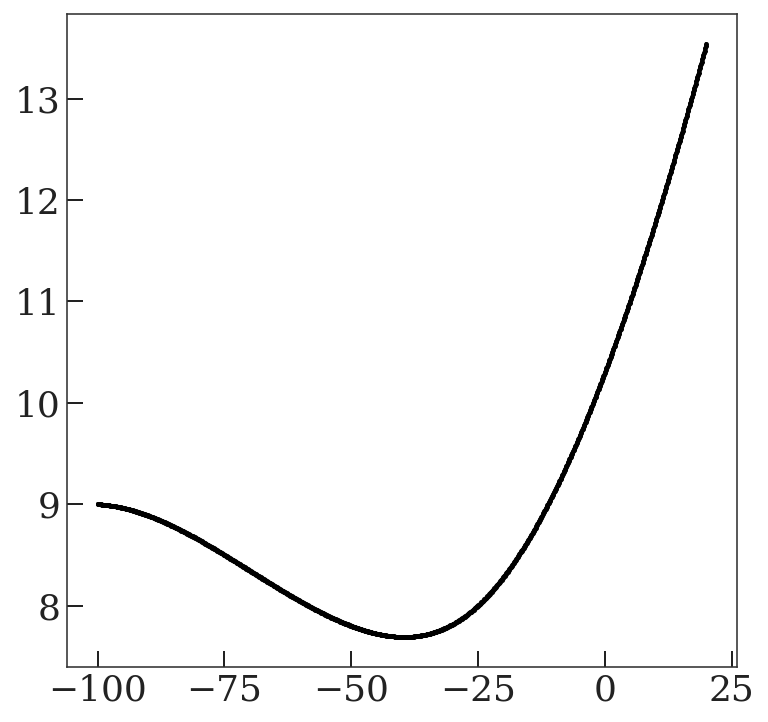

In [49]:
func = interp1d(
    [-100, -75, -50, -25, 0, 12.5], 
    [9, 8.5, 7.8, 8, 10.3, 12.2], 
    kind='cubic', 
    fill_value='extrapolate',
)
grid = np.linspace(-100, 20, 1024)
plt.plot(grid, func(grid))

dists = func(c_tmp.phi1.degree)

In [50]:
c_gd1 = g.get_skycoord(
    distance=dists * u.kpc, 
    radial_velocity=0*u.km/u.s
).transform_to(gc.GD1Koposov10())
c_gd1 = gc.reflex_correct(c_gd1)

(-10.0, 10.0)

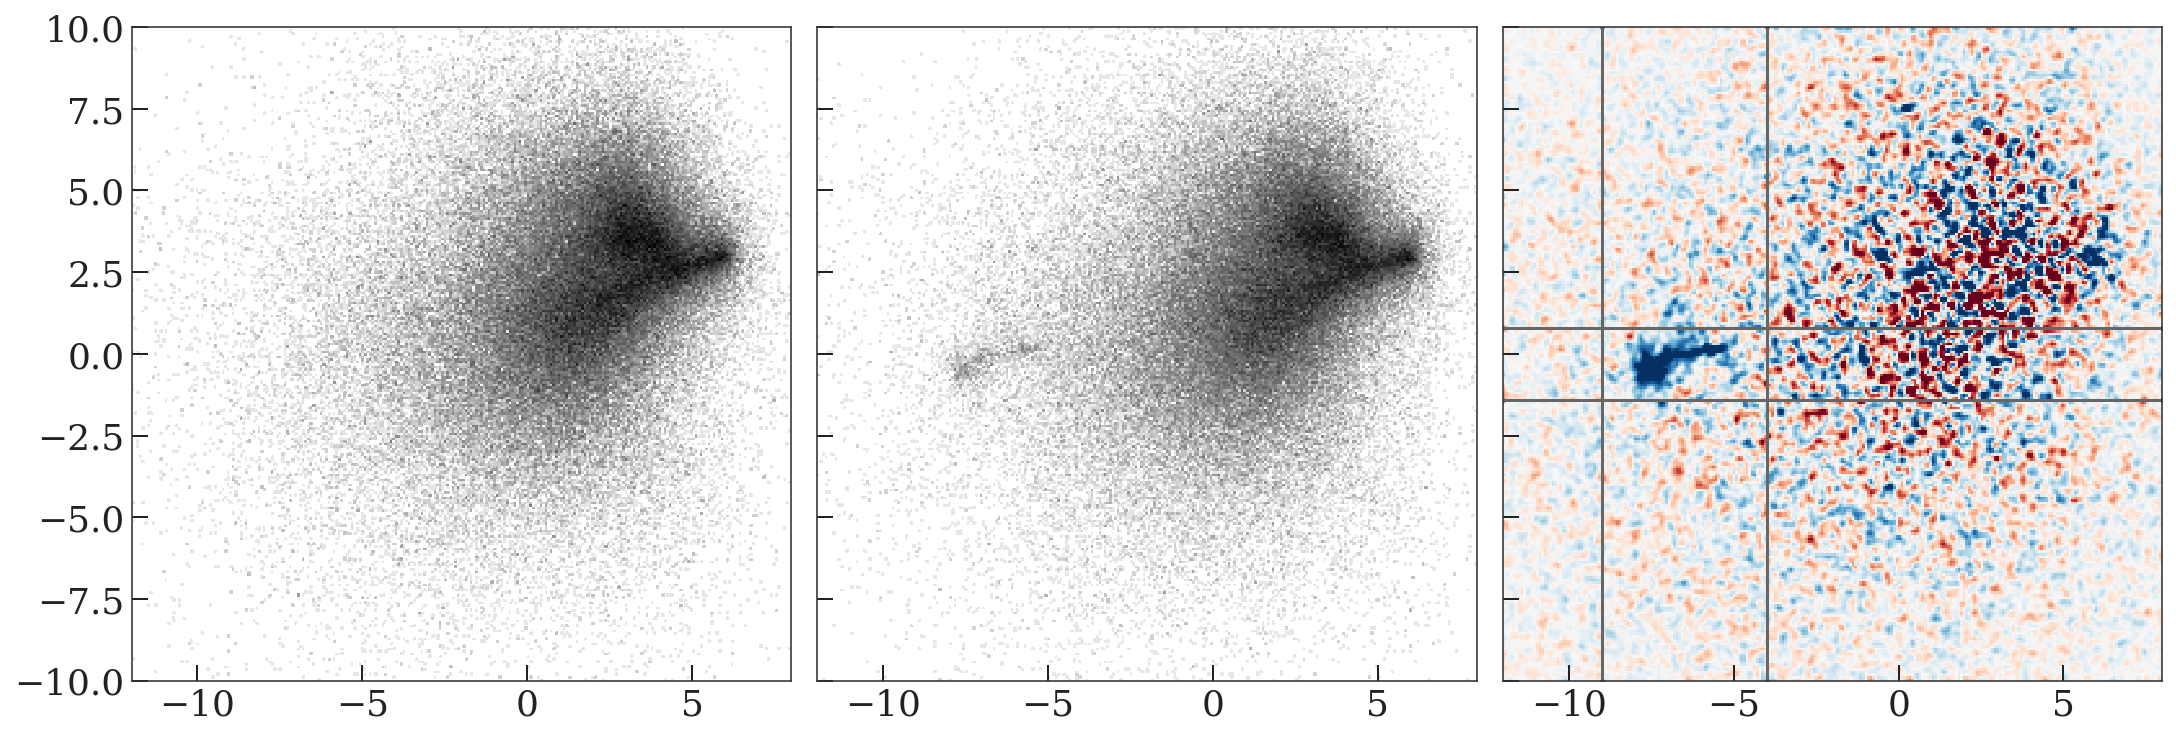

In [51]:
phi1_mask = (
    (c_gd1.phi1.wrap_at(180*u.deg) > -80*u.deg) & 
    (c_gd1.phi1.wrap_at(180*u.deg) < 10*u.deg)
)

phi2_mask_on = (np.abs(c_gd1.phi2) < 1*u.deg)
phi2_mask_off = (
    ((c_gd1.phi2 > 1.5*u.deg) & (c_gd1.phi2 < 2.5*u.deg)) |
    ((c_gd1.phi2 > -3*u.deg) & (c_gd1.phi2 < -2*u.deg))
)

bins = (
    np.linspace(-12, 8, 256),
    np.linspace(-10, 10, 256),
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

ax = axes[0]
_mask = phi1_mask & phi2_mask_off
H_off, xe, ye, *_ = ax.hist2d(
    c_gd1.pm_phi1_cosphi2[_mask].value, 
    c_gd1.pm_phi2[_mask].value, 
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap='Greys'
)

ax = axes[1]
_mask = phi1_mask & phi2_mask_on
H_on, xe, ye, *_ = ax.hist2d(
    c_gd1.pm_phi1_cosphi2[_mask].value, 
    c_gd1.pm_phi2[_mask].value, 
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap='Greys'
)

ax = axes[2]
ax.pcolormesh(
    xe, ye, 
    # (gaussian_filter(H_on, 1) - gaussian_filter(H_off, 1)).T,
    gaussian_filter((H_on - H_off), 1).T,
    cmap='RdBu',
    vmin=-2, 
    vmax=2
)

pm1_lim = [-9, -4] * u.mas/u.yr
pm2_lim = [-1.4, 0.8] * u.mas/u.yr
for p in pm1_lim.value:
    ax.axvline(p)
for p in pm2_lim.value:
    ax.axhline(p)

ax.set_xlim(-12, 8)
ax.set_ylim(-10, 10)

In [52]:
pm_mask = (
    (c_gd1.pm_phi1_cosphi2 > pm1_lim[0]) &
    (c_gd1.pm_phi1_cosphi2 < pm1_lim[1]) &
    (c_gd1.pm_phi2 > pm2_lim[0]) &
    (c_gd1.pm_phi2 < pm2_lim[1])
)
pm_mask.sum()

35112

(-10.0, 5.0)

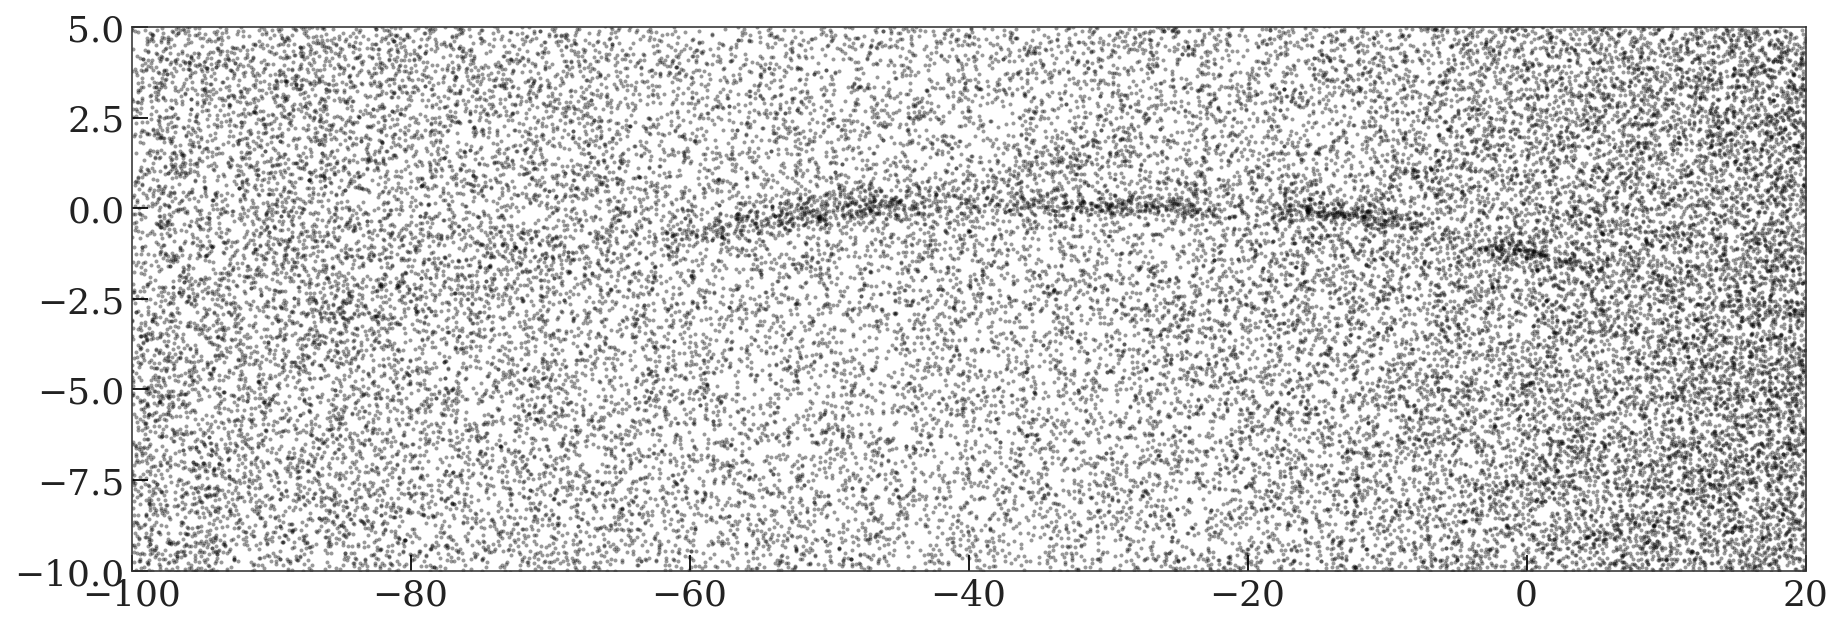

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(
    c_gd1.phi1.wrap_at(180*u.deg).value[pm_mask],
    c_gd1.phi2.value[pm_mask], 
    marker='o',
    mew=0,
    ls='none',
    ms=2.,
    alpha=0.4
)
ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

In [44]:
ebv = g.get_ebv()

In [45]:
Ag = 3.172 * ebv
Ai = 1.682 * ebv

g0 = g.gMeanPSFMag - Ag
i0 = g.iMeanPSFMag - Ai

In [54]:
col = g0 - i0
mag = g0 - c_gd1.distance.distmod.value

(-1.0, 1.5)

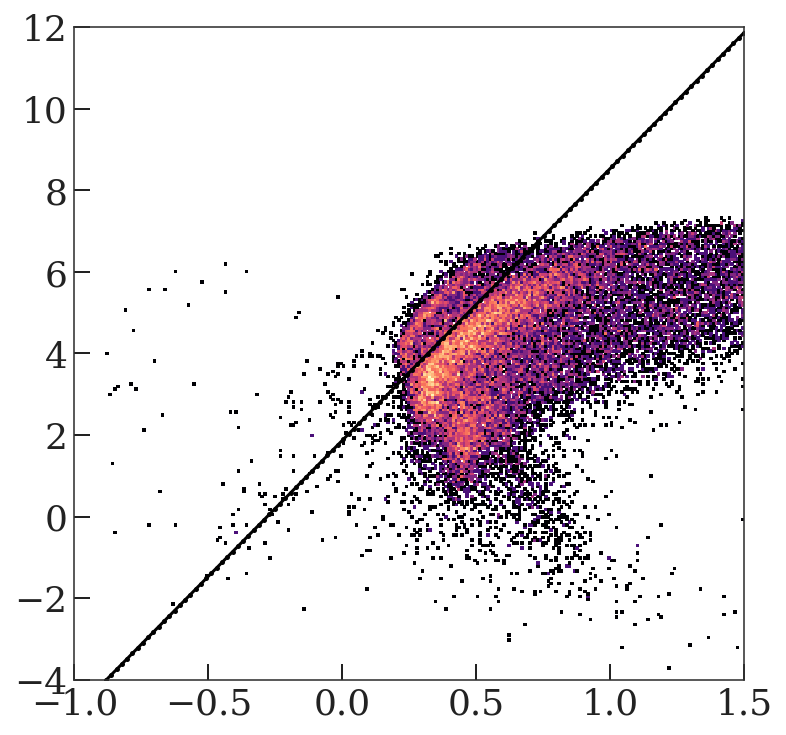

In [72]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(
    col[pm_mask],
    mag[pm_mask], 
    bins=(np.linspace(-1, 1.5, 256),
          np.linspace(-4, 12, 256)), 
    norm=mpl.colors.LogNorm()
);

_grid = np.linspace(-1, 1.5, 128)
ax.plot(_grid, 1/0.15 * (_grid - 0.5) + 5.2)

ax.set_xlim(-1, 1.5)
# ax.set_ylim(7, -3)

In [73]:
cmd_mask = mag > (1/0.15 * (col - 0.5) + 5.2)

(-10.0, 5.0)

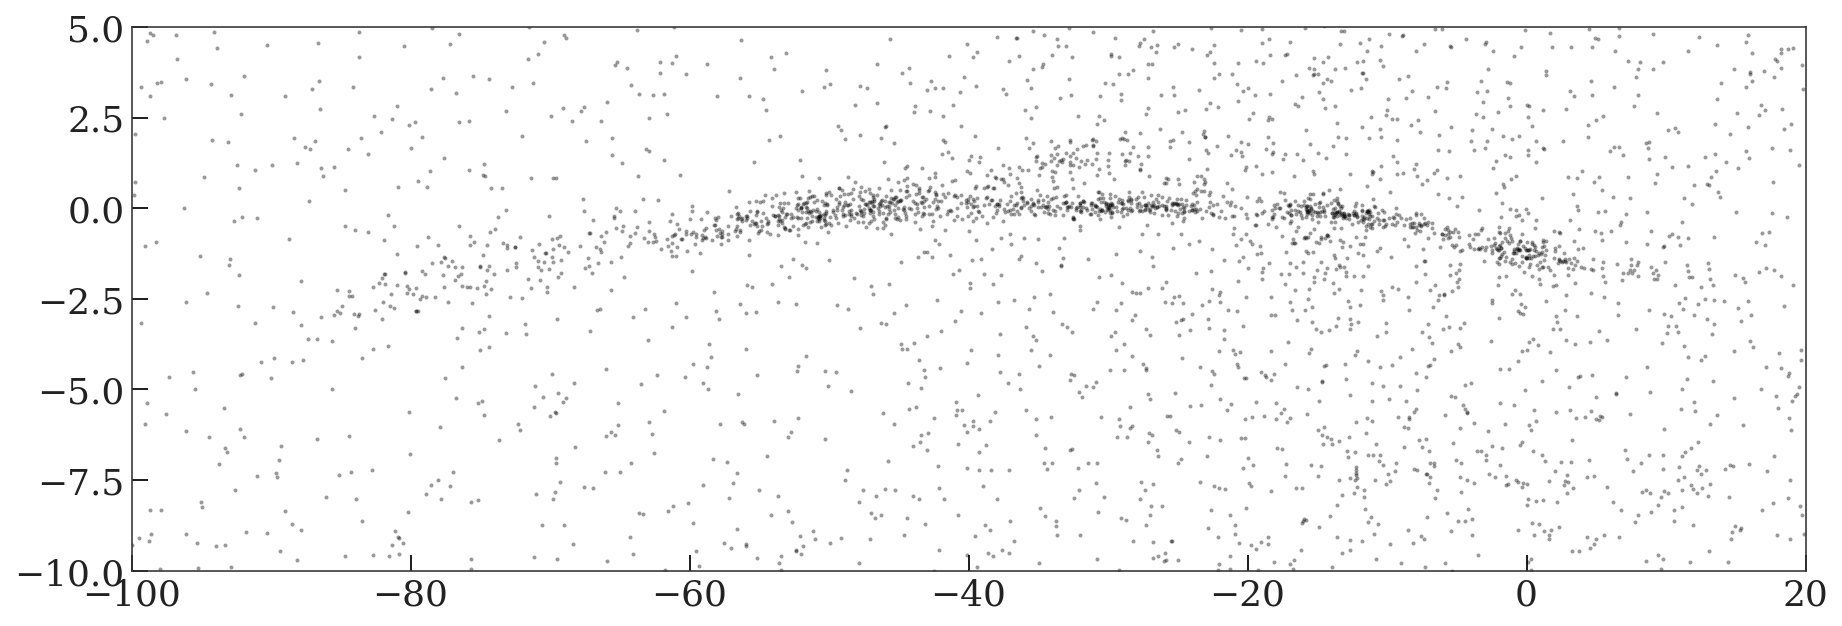

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(
    c_gd1.phi1.wrap_at(180*u.deg).value[cmd_mask & pm_mask],
    c_gd1.phi2.value[cmd_mask & pm_mask], 
    marker='o',
    mew=0,
    ls='none',
    ms=2.,
    alpha=0.4
)
ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

In [76]:
g.data[cmd_mask & pm_mask].write('../data/tmp/gd1-gaiadr3-blog.fits')